# Questions 
- df_per 
- model range numbers 
- what to do with missing data 
- loc[0000]
- why the last cell 
- this notebook throws an error if data is missing largely 

#### this script will detect missing days of data

In [15]:
import glob
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Functions

In [16]:
"""
 do_all_days_exist
prints how many missing days there are in your dataset

 ARGS: 
 df: dataframe ::
 year: string :: 0000
 month: string :: 00

 RETURNS: 
 """


def do_all_days_exist(df, year, month):
    daysinmonth = calendar.monthrange(int(year), int(month))[1]  # get all days in month
    downloaded_days = len(df["init_date"].unique())
    if daysinmonth != downloaded_days:
        print(f"🚨🚨🚨 there are {daysinmonth-downloaded_days} days of data missing! 🚨🚨🚨")


"""
 find_available_data_percentage
prints how many missing days there are in your dataset

 ARGS: 
 df: dataframe ::
 year: string :: 0000
 month: string :: 00
 model: string :: model name 
 df_per: 

 RETURNS: 
df_per: 
 """


def find_available_data_percentage(df: pd.DataFrame, year, month, model, df_per):
    init00 = "0000"
    init12 = "1200"
    if model == "HRRR":
        fh = range(0, 19)  # (0, 19)forecast hours, second num exclusive
        init00 = "t00z"
        init12 = "t12z"
    elif model == "NAM":
        fh = np.arange(0, 37, 1).tolist() + np.arange(39, 85, 3).tolist()
    elif model == "GFS":
        fh = np.arange(0, 99, 3)

    daysinmonth = calendar.monthrange(int(year), int(month))[1]  # get all days in month
    allpossiblefiles = daysinmonth * len(fh)
    print("allpossiblefiles", allpossiblefiles)
    utc_00 = (
        df.groupby(["init_hour", "init_date"]).count().loc[init00]["file_path"].sum()
    )
    utc_12 = (
        df.groupby(["init_hour", "init_date"]).count().loc[init12]["file_path"].sum()
    )
    print("utc_00", utc_00)

    per00 = 100.0 * (utc_00 / allpossiblefiles)
    per12 = 100.0 * (utc_12 / allpossiblefiles)
    print(f"{per00:0.1f}% of 00 UTC data is available")
    print(f"{per12:0.1f}% of 12 UTC data is available")
    df_per.loc[month]["00 UTC"] = per00.round(1)
    df_per.loc[month]["12 UTC"] = per12.round(1)
    return df_per


"""
plot_data_heatmap
returns a heatmap graph of how much data is missing in your dataset 

 ARGS: 
df_per: 
model: string :: model name 
year: string :: 0000

 RETURNS: 
 """


def plot_data_heatmap(df_per, model, year):
    plt.figure(figsize=(3, 5))
    sns.heatmap(
        df_per.astype(float),
        linewidths=0.1,
        annot=True,
        fmt="2g",
        vmin=90,
        vmax=100,
        cmap=cm.cividis_r,
    )
    plt.ylabel("Month")
    plt.xlabel("Initialization Time")
    plt.title(f"{model}: {year}")
    plt.tight_layout()
    # plt.savefig(f'../Figures/files_exist_{model}_{year}.png', dpi=200, facecolor='white', transparent=False)

# Main 

In [17]:
def main(model, year):
    if model != "HRRR":
        file_exten = ".grb2"
    else:
        file_exten = ".grib2"

    # files to be checked
    fp = f"/home/aevans/ai2es/{model}/{year}/"

    df_per = pd.DataFrame(columns=["00 UTC", "12 UTC"], index=np.arange(1, 13))

    for month in range(1, 13):
        print("--------------")
        print(calendar.month_name[month])
        print("--------------")

        # What is glob ??
        # glob.glob(pathname, *, root_dir=None, dir_fd=None, recursive=False, include_hidden=False)
        files = glob.glob(f"{fp}{str(month).zfill(2)}/*{file_exten}")
        files.sort()

        # this is returned
        df = pd.DataFrame(files, columns=["file_path"])
        # what is lambda x: x.split()
        # sorts through strings and returns the value specified

        df["file_name"] = df["file_path"].apply(lambda x: x.split("/")[-1])
        if model != "HRRR":
            df["init_date"] = df["file_name"].apply(lambda x: x.split("_")[2])
            df["init_hour"] = df["file_name"].apply(lambda x: x.split("_")[3])
        else:
            df["init_date"] = df["file_name"].apply(lambda x: x.split("_")[0])
            df["init_hour"] = (
                df["file_name"]
                .apply(lambda x: x.split("_")[1])
                .apply(lambda x: x.split(".")[1])
            )

        groupby_count = df.groupby(["init_date"]).count()
        print("groupby_count", groupby_count)

        do_all_days_exist(df, year, month)

        if groupby_count.min()[0] != groupby_count.max()[0]:
            print("max: ", groupby_count.max()[0])
            print(
                groupby_count.loc[groupby_count["init_hour"] < groupby_count.max()[0]]
            )
            print(
                "potentially missing files: ",
                groupby_count.loc[
                    groupby_count["init_hour"] == groupby_count.min()[0]
                ].index,
            )
        else:
            print("no missing files")

        # this is returned
        df_per = find_available_data_percentage(df, year, month, model, df_per)
        df_per = df_per.fillna(0)
        print(df_per)

    return df, df_per

--------------
January
--------------
groupby_count            file_path  file_name  init_hour
init_date                                 
20210101          66         66         66
20210102          66         66         66
20210103          66         66         66
20210104          66         66         66
20210105          66         66         66
20210106          66         66         66
20210107          66         66         66
20210108          66         66         66
20210109          66         66         66
20210110          66         66         66
20210111          66         66         66
20210112          66         66         66
20210113          66         66         66
20210114          66         66         66
20210115          66         66         66
20210116          66         66         66
20210117          66         66         66
20210118          66         66         66
20210119          66         66         66
20210120          66         66         66
20

KeyError: '0000'

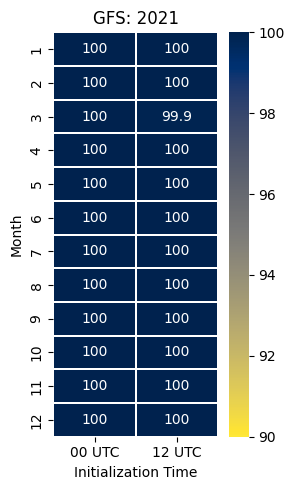

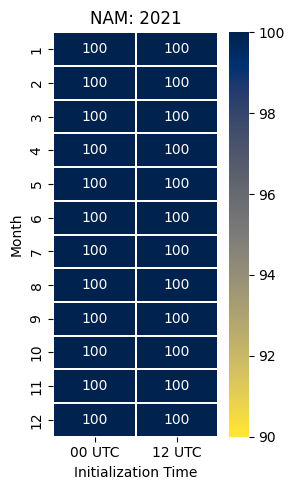

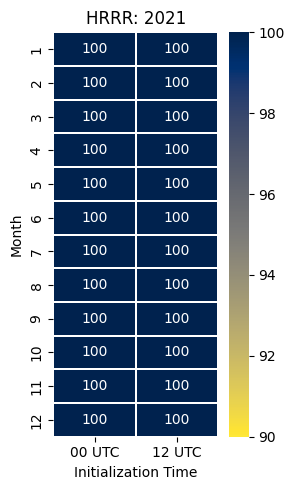

In [18]:
years = [2021, 2022, 2023]
models = ["GFS", "NAM", "HRRR"]


if models[0] == "HRRR":
    fh = range(0, 19)
elif models[0] == "NAM":
    fh = np.arange(0, 37, 1).tolist() + np.arange(39, 85, 3).tolist()
elif models[0] == "GFS":
    fh = np.arange(0, 99, 3)

for year in years:
    for model in models:
        df, df_per = main(model, year)
        plot_data_heatmap(df_per, model, year)

In [ ]:
df.groupby(["init_hour", "init_date"]).count().loc["t00z"]

,file_path,file_name
init_date,,
20211201,19,19
20211202,19,19
20211203,19,19
20211204,19,19
20211205,19,19
20211206,19,19
20211207,19,19
20211208,19,19
20211209,19,19


In [ ]:
df.groupby(["init_hour", "init_date"]).count().loc["t00z"]["file_path"]

init_date
20211201    19
20211202    19
20211203    19
20211204    19
20211205    19
20211206    19
20211207    19
20211208    19
20211209    19
20211210    19
20211211    19
20211212    19
20211213    19
20211214    19
20211215    19
20211216    19
20211217    19
20211218    19
20211219    19
20211220    19
20211221    19
20211222    19
20211223    19
20211224    19
20211225    19
20211226    19
20211227    19
20211228    19
20211229    19
20211230    19
20211231    19
Name: file_path, dtype: int64